In [1]:
 import os
# Find the latest version of spark 3.0  from http://www-us.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.0.2'
spark_version = 'spark-3.1.2'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Hit:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:3 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:4 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:5 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:7 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:8 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:9 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:13 https://developer.download.nvidia.com/compute/machine-le

In [2]:
!wget https://jdbc.postgresql.org/download/postgresql-42.2.9.jar

--2021-08-31 21:11:29--  https://jdbc.postgresql.org/download/postgresql-42.2.9.jar
Resolving jdbc.postgresql.org (jdbc.postgresql.org)... 72.32.157.228, 2001:4800:3e1:1::228
Connecting to jdbc.postgresql.org (jdbc.postgresql.org)|72.32.157.228|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 914037 (893K) [application/java-archive]
Saving to: ‘postgresql-42.2.9.jar.3’

postgresql-42.2.9.j 100%[===================>] 892.61K  1.76MB/s    in 0.5s    

2021-08-31 21:11:31 (1.76 MB/s) - ‘postgresql-42.2.9.jar.3’ saved [914037/914037]



In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [4]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("CloudETL").config("spark.driver.extraClassPath","/content/postgresql-42.2.9.jar").getOrCreate()

In [5]:
# Read in data from S3 Buckets
from pyspark import SparkFiles

# test data
url="https://data-bootcamp-titanic.s3.us-east-2.amazonaws.com/test.csv"
spark.sparkContext.addFile(url)
test_df = spark.read.csv(SparkFiles.get("test.csv"), sep=",", header=True, inferSchema=True)

# train data
url="https://data-bootcamp-titanic.s3.us-east-2.amazonaws.com/train.csv"
spark.sparkContext.addFile(url)
train_df = spark.read.csv(SparkFiles.get("train.csv"), sep=",", header=True, inferSchema=True)

# Show DataFrame
test_df.show()
train_df.show()

+-----------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|        892|     3|    Kelly, Mr. James|  male|34.5|    0|    0|          330911| 7.8292| null|       Q|
|        893|     3|Wilkes, Mrs. Jame...|female|47.0|    1|    0|          363272|    7.0| null|       S|
|        894|     2|Myles, Mr. Thomas...|  male|62.0|    0|    0|          240276| 9.6875| null|       Q|
|        895|     3|    Wirz, Mr. Albert|  male|27.0|    0|    0|          315154| 8.6625| null|       S|
|        896|     3|Hirvonen, Mrs. Al...|female|22.0|    1|    1|         3101298|12.2875| null|       S|
|        897|     3|Svensson, Mr. Joh...|  male|14.0|    0|    0|            7538|  9.225| null|       S|
|        898|     3|Connolly, Miss. Kate|femal

In [6]:
# Convert pyspark dataframes to pandas
pd_train_df = train_df.toPandas()
pd_test_df = test_df.toPandas()

# Begin Machine Learning

## Univariate Linear Regression Models

In [7]:
from sklearn.linear_model import LinearRegression


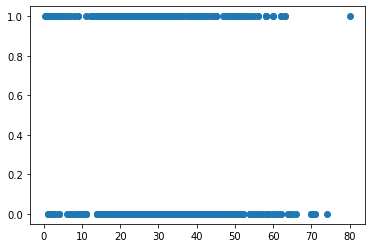

In [8]:
# Linear Regression of Age
age_data = pd_train_df.copy()

# drop nas from Age column
age_data = age_data[age_data['Age'].notna()]

# assign data to X and y
X = age_data["Age"].values.reshape(-1,1)
y = age_data["Survived"].values.reshape(-1,1)

plt.scatter(X,y)

### upon making the above 'model' I realized linear regression doesn't make sense. Moving on to logistical models. We can also tell that age isn't a good predictor of survival alone 

# Logistic Regression

In [9]:
# Logistic Regression 
from sklearn.linear_model import LogisticRegression
clf1 = LogisticRegression(solver='liblinear')

# Split train_df into testing and training dataframes since we don't have access to the survival column of the given test data
from sklearn.model_selection import train_test_split


# Create X_train and y_train
    # drop PassengerId, Ticket, Cabin, Name, and Embarked columns bc they don't seem to hold any logical relevance to survival (if more time-- test this statement!)
X = pd_train_df.drop(["PassengerId","Ticket","Cabin", "Name", "Embarked"], axis=1)
X = X.dropna()
y = X["Survived"]
X = X.drop(["Survived"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=420)

In [10]:
# Encode Sex and Passenger Class
X_train = pd.get_dummies(X_train, columns=["Sex", "Pclass"])
X_test = pd.get_dummies(X_test, columns=["Sex", "Pclass"])

In [11]:
# Bin Fare for encoding
bins = [0, 8.05, 15.7417, 33.375, 100, 513]
labels = ["cheapest", "cheap", "medium", "expensive", "most expensive"]
X_train["Fare cat."] = pd.cut(X_train["Fare"], bins, labels=labels)
X_test["Fare cat."] = pd.cut(X_test["Fare"], bins, labels=labels)

# Encode Fare
X_train = pd.get_dummies(X_train, columns=["Fare cat."])
X_test = pd.get_dummies(X_test, columns=["Fare cat."])

# drop Fare columns
X_train = X_train.drop(columns=["Fare", "Parch", "SibSp"])
X_test = X_test.drop(columns=["Fare", "Parch", "SibSp"])

X_train.head(1)

,Age,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Fare cat._cheapest,Fare cat._cheap,Fare cat._medium,Fare cat._expensive,Fare cat._most expensive
282,16.0,0,1,0,0,1,0,1,0,0,0


In [12]:
X_test.head(1)

,Age,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Fare cat._cheapest,Fare cat._cheap,Fare cat._medium,Fare cat._expensive,Fare cat._most expensive
749,31.0,0,1,0,0,1,1,0,0,0,0


In [13]:
clf1.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [14]:
print(f"Training Data Score: {clf1.score(X_train, y_train)}")
print(f"Testing Data Score: {clf1.score(X_test, y_test)}")

Training Data Score: 0.7869158878504673
Testing Data Score: 0.8379888268156425


# IT'S BETTER THAN RANDOM

In [16]:
predictions = clf1.predict(X_test)
pred_df = pd.DataFrame({
    "Age": X_test["Age"],
    "Sex_female": X_test["Sex_female"],
    "Sex_male":	X_test["Sex_male"],
    "Pclass_1": X_test["Pclass_1"],
    "Pclass_2": X_test["Pclass_2"],
    "Pclass_3":	X_test["Pclass_3"],
    "Fare-cheapest": X_test["Fare cat._cheapest"],
    "Fare-cheap": X_test[ "Fare cat._cheap"],
    "Fare-medium": X_test["Fare cat._medium"],
    "Fare-expensive": X_test[ "Fare cat._expensive"],
    "Fare-most expensive": X_test["Fare cat._most expensive"],
    "[Prediction": predictions, 
    "Actual]": y_test
    }).reset_index(drop=True)
pred_df.head(20)

,Age,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Fare-cheapest,Fare-cheap,Fare-medium,Fare-expensive,Fare-most expensive,[Prediction,Actual]
0,31.0,0,1,0,0,1,1,0,0,0,0,0,0
1,28.0,1,0,0,1,0,0,1,0,0,0,1,1
2,24.0,0,1,0,0,1,1,0,0,0,0,0,0
3,28.5,0,1,0,0,1,0,0,1,0,0,0,0
4,29.0,0,1,0,0,1,1,0,0,0,0,0,0
5,28.0,0,1,0,0,1,1,0,0,0,0,0,0
6,41.0,1,0,0,1,0,0,0,1,0,0,1,1
7,29.0,1,0,0,0,1,0,1,0,0,0,0,1
8,44.0,0,1,0,0,1,1,0,0,0,0,0,1
9,28.0,0,1,0,1,0,0,0,1,0,0,0,0


In [17]:
# print all the rows where our model got the prediction wrong
wrong_df = pred_df.loc[pred_df["[Prediction"] != pred_df["Actual]"],:]
wrong_indexi = wrong_df.index
pd_train_df.iloc[wrong_indexi,:]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,None,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,None,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S
12,13,0,3,"Saundercock, Mr. William Henry",male,20.0,0,0,A/5. 2151,8.0500,None,S
35,36,0,1,"Holverson, Mr. Alexander Oskar",male,42.0,1,0,113789,52.0000,None,S
41,42,0,2,"Turpin, Mrs. William John Robert (Dorothy Ann ...",female,27.0,1,0,11668,21.0000,None,S
47,48,1,3,"O'Driscoll, Miss. Bridget",female,NaN,0,0,14311,7.7500,None,Q
67,68,0,3,"Crease, Mr. Ernest James",male,19.0,0,0,S.P. 3464,8.1583,None,S
68,69,1,3,"Andersson, Miss. Erna Alexandra",female,17.0,4,2,3101281,7.9250,None,S
75,76,0,3,"Moen, Mr. Sigurd Hansen",male,25.0,0,0,348123,7.6500,F G73,S


# Logistic Regression model using Age encoding
- 1st with several bins
- then with just two bins "minor" and "adult

In [18]:
# Bin Ages so Hot Coding can be done
X_train_copy = X_train.copy()
bins = [0, 1, 4, 12, 19, 24, 29, 34, 39, 65, 80]
labels = ["infant", "toddler", "child", "teenager", "early 20s", "late 20s", "early 30s", "late 30s", "40-65", "65+"]
X_train_copy["Age Range"] = pd.cut(X_train_copy["Age"], bins, labels=labels)
X_train_copy = X_train_copy.drop(["Age"], axis=1)

X_test_copy = X_test.copy()
X_test_copy["Age Range"] = pd.cut(X_test_copy["Age"], bins, labels=labels)
X_test_copy = X_test_copy.drop(["Age"], axis=1)

Encode Age Range


In [19]:
X_train_copy = pd.get_dummies(X_train_copy, columns=["Age Range"])
X_test_copy = pd.get_dummies(X_test_copy, columns=["Age Range"])
X_train_copy.head(1)

,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Fare cat._cheapest,Fare cat._cheap,Fare cat._medium,Fare cat._expensive,Fare cat._most expensive,Age Range_infant,Age Range_toddler,Age Range_child,Age Range_teenager,Age Range_early 20s,Age Range_late 20s,Age Range_early 30s,Age Range_late 30s,Age Range_40-65,Age Range_65+
282,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0


fit classifier to data

In [20]:
clf2 = LogisticRegression(solver='liblinear')
clf2.fit(X_train_copy,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [21]:
print(f"Training Data Score: {clf2.score(X_train_copy, y_train)}")
print(f"Testing Data Score: {clf2.score(X_test_copy, y_test)}")

Training Data Score: 0.7962616822429907
Testing Data Score: 0.8379888268156425


### Minor vs Adult Encoding

In [22]:
clf3 = LogisticRegression(solver='liblinear')
# find the most accurate minor age to fit with by looping through a range of cut-off ages
best_score = 0
best_x = 0
for x in range(10,21):
  X_train_copy = X_train.copy()
  bins = [0,x,100]
  labels = ["minor", "adult"]
  X_train_copy["Age Range"] = pd.cut(X_train_copy["Age"], bins, labels=labels)
  X_train_copy = X_train_copy.drop(["Age"], axis=1)
  X_train_copy = pd.get_dummies(X_train_copy, columns=["Age Range"])
  clf3.fit(X_train_copy,y_train)
  score = clf3.score(X_train_copy,y_train)
  print(f"Training Data Score X == {x}: {round(score,4)}")

  if score > best_score:
    best_x = x
    best_score = score
    best_model = clf3

print(f'\n{best_x} is where we get the best score of {round(best_score,4)}')

Training Data Score X == 10: 0.8093
Training Data Score X == 11: 0.8093
Training Data Score X == 12: 0.8093
Training Data Score X == 13: 0.8093
Training Data Score X == 14: 0.8112
Training Data Score X == 15: 0.8112
Training Data Score X == 16: 0.8075
Training Data Score X == 17: 0.8131
Training Data Score X == 18: 0.7925
Training Data Score X == 19: 0.7907
Training Data Score X == 20: 0.7888

17 is where we get the best score of 0.8131


In [23]:
# recut and fit train data to age cut-off of 17; 
X_train_copy = X_train.copy()
bins = [0,17,100]
labels = ["minor", "adult"]
X_train_copy["Age Range"] = pd.cut(X_train_copy["Age"], bins, labels=labels)
X_train_copy = X_train_copy.drop(["Age"], axis=1)
X_train_copy = pd.get_dummies(X_train_copy, columns=["Age Range"])
clf3.fit(X_train_copy,y_train)

# cut and encode test data
X_test_copy = X_test.copy()
X_test_copy["Age Range"] = pd.cut(X_test_copy["Age"], bins, labels=labels)
X_test_copy = X_test_copy.drop(["Age"], axis=1)
X_test_copy = pd.get_dummies(X_test_copy, columns=["Age Range"])

In [24]:
print(f"Training Data Score: {clf3.score(X_train_copy, y_train)}")
print(f"Testing Data Score: {clf3.score(X_test_copy, y_test)}")

Training Data Score: 0.8130841121495327
Testing Data Score: 0.8044692737430168


In [25]:
predictions = clf3.predict(X_test_copy)
pred_df = pd.DataFrame({
    "Prediction": predictions, 
    "Actual": y_test
    }).reset_index(drop=True)
pred_df.head(20)

,Prediction,Actual
0,0,0
1,1,1
2,0,0
3,0,0
4,0,0
5,0,0
6,1,1
7,0,1
8,0,1
9,0,0


In [26]:
# print all the rows where our model got the prediction wrong using the test data
wrong_df = pred_df.loc[pred_df["Prediction"] != pred_df["Actual"],:]
wrong_indexi = wrong_df.index
pd_train_df.iloc[wrong_indexi,:]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.00,3,1,349909,21.0750,None,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.00,0,2,347742,11.1333,None,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.00,0,0,113783,26.5500,C103,S
12,13,0,3,"Saundercock, Mr. William Henry",male,20.00,0,0,A/5. 2151,8.0500,None,S
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,None,S
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.00,3,2,19950,263.0000,C23 C25 C27,S
35,36,0,1,"Holverson, Mr. Alexander Oskar",male,42.00,1,0,113789,52.0000,None,S
36,37,1,3,"Mamee, Mr. Hanna",male,NaN,0,0,2677,7.2292,None,C
41,42,0,2,"Turpin, Mrs. William John Robert (Dorothy Ann ...",female,27.00,1,0,11668,21.0000,None,S
47,48,1,3,"O'Driscoll, Miss. Bridget",female,NaN,0,0,14311,7.7500,None,Q


# KNN Model
- Start with Original DF
- clean data
- encode Sex and Age
- split, train, trainsform and test

In [27]:
from sklearn.neighbors import KNeighborsClassifier

In [28]:
# Create X_train and y_train fresh from pd_train_df
   # remember: using pd_train_df to split because we don't have access to test_df's survival info (I.E., 'y_test')

X = pd_train_df.drop(columns=["Name", "Ticket", "Cabin", "Fare", "PassengerId", "Embarked"])
X = X.dropna()
y = X["Survived"]
X = X.drop(["Survived"], axis=1)

In [29]:
# Encode Sex and Age

X["Sex"][X["Sex"] == 'male'] = 1
X["Sex"][X["Sex"] == 'female'] = 2
X["Adult"] = 0
X["Adult"][X["Age"] >= 15] = 1
X = X.drop("Age", axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

In [30]:
X.head()

,Pclass,Sex,SibSp,Parch,Adult
0,3,1,1,0,1
1,1,2,1,0,1
2,3,2,0,0,1
3,1,2,1,0,1
4,3,1,0,0,1


In [31]:
# split data into testing and training 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


In [32]:
from sklearn.preprocessing import StandardScaler

# Create a StandardScater model and fit it to the training data

X_scaler = StandardScaler().fit(X_train)

In [33]:
# Transform the training and testing data 
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

k: 1, Train/Test Score: 0.802/0.788
k: 3, Train/Test Score: 0.836/0.827
k: 5, Train/Test Score: 0.830/0.821
k: 7, Train/Test Score: 0.830/0.821
k: 9, Train/Test Score: 0.830/0.821
k: 11, Train/Test Score: 0.828/0.810
k: 13, Train/Test Score: 0.830/0.821
k: 15, Train/Test Score: 0.826/0.821
k: 17, Train/Test Score: 0.832/0.816
k: 19, Train/Test Score: 0.832/0.816
k: 21, Train/Test Score: 0.828/0.816
k: 23, Train/Test Score: 0.824/0.821
k: 25, Train/Test Score: 0.834/0.810
k: 27, Train/Test Score: 0.832/0.810
k: 29, Train/Test Score: 0.826/0.810
k: 31, Train/Test Score: 0.830/0.810
k: 33, Train/Test Score: 0.822/0.816
k: 35, Train/Test Score: 0.821/0.804
k: 37, Train/Test Score: 0.824/0.804
k: 39, Train/Test Score: 0.807/0.788
k: 41, Train/Test Score: 0.813/0.788
k: 43, Train/Test Score: 0.815/0.788
k: 45, Train/Test Score: 0.817/0.799
k: 47, Train/Test Score: 0.802/0.777
k: 49, Train/Test Score: 0.806/0.788


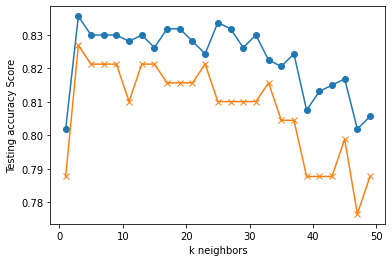

In [34]:
# Loop through different k values to see which has the highest accuracy

train_scores = []
test_scores = []
for k in range(1, 50, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    train_score = knn.score(X_train_scaled, y_train)
    test_score = knn.score(X_test_scaled, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train/Test Score: {train_score:.3f}/{test_score:.3f}")
    
    
plt.plot(range(1, 50, 2), train_scores, marker='o')
plt.plot(range(1, 50, 2), test_scores, marker="x")
plt.xlabel("k neighbors")
plt.ylabel("Testing accuracy Score")
plt.show()

In [35]:
# Note that k: 15 seems to be the best choice for this dataset
knn1 = KNeighborsClassifier(n_neighbors=15)
knn1.fit(X_train_scaled, y_train)


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=15, p=2,
                     weights='uniform')

### Drop Siblings and Parents aboard count to see if our accuracy improves 

In [36]:
X = X.drop(columns=["SibSp", "Parch"])

In [37]:
X.head()

,Pclass,Sex,Adult
0,3,1,1
1,1,2,1
2,3,2,1
3,1,2,1
4,3,1,1


k: 1, Train/Test Score: 0.578/0.503
k: 3, Train/Test Score: 0.578/0.503
k: 5, Train/Test Score: 0.811/0.793
k: 7, Train/Test Score: 0.811/0.793
k: 9, Train/Test Score: 0.811/0.793
k: 11, Train/Test Score: 0.798/0.782
k: 13, Train/Test Score: 0.811/0.793
k: 15, Train/Test Score: 0.811/0.793
k: 17, Train/Test Score: 0.811/0.793
k: 19, Train/Test Score: 0.811/0.793
k: 21, Train/Test Score: 0.811/0.793
k: 23, Train/Test Score: 0.811/0.793
k: 25, Train/Test Score: 0.798/0.782
k: 27, Train/Test Score: 0.798/0.782
k: 29, Train/Test Score: 0.798/0.782
k: 31, Train/Test Score: 0.798/0.782
k: 33, Train/Test Score: 0.798/0.782
k: 35, Train/Test Score: 0.798/0.782
k: 37, Train/Test Score: 0.798/0.782
k: 39, Train/Test Score: 0.798/0.782
k: 41, Train/Test Score: 0.798/0.782
k: 43, Train/Test Score: 0.798/0.782
k: 45, Train/Test Score: 0.798/0.782
k: 47, Train/Test Score: 0.798/0.782
k: 49, Train/Test Score: 0.798/0.782


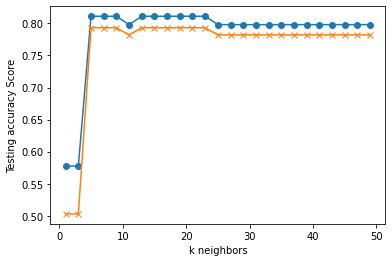

In [38]:
# split data into testing and training 
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Create a StandardScater model and fit it to the training data
X_scaler = StandardScaler().fit(X_train)

# Transform the training and testing data 
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Loop through different k values to see which has the highest accuracy

train_scores = []
test_scores = []
for k in range(1, 50, 2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    train_score = knn.score(X_train_scaled, y_train)
    test_score = knn.score(X_test_scaled, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f"k: {k}, Train/Test Score: {train_score:.3f}/{test_score:.3f}")
    
    
plt.plot(range(1, 50, 2), train_scores, marker='o')
plt.plot(range(1, 50, 2), test_scores, marker="x")
plt.xlabel("k neighbors")
plt.ylabel("Testing accuracy Score")
plt.show()

In [39]:
# Note that without Sibs and Parents, k: 13 seems t obe the best neighbor-count
knn2 = KNeighborsClassifier(n_neighbors=13)
knn2.fit(X_train_scaled, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=13, p=2,
                     weights='uniform')